# Exercise 2
Consider the grid-world shown in the below figure. In each (non-grey) cell, it is possible to perform five actions: move up, down, left, right, or do nothing, as long as the resulting move stays inside the grid world. Grey cells are obstacles and are not allowed. We would like to find the optimal value function and optimal policy that minimize the following cost:

$$
\min \sum_{n=0}^{\infty} \alpha^n g_n(x_n)
$$

with discount factor $ \alpha = 0.99 $ and where the instantaneous cost is defined as:

$$
g_n(x_n) = 
\begin{cases}
-1 & \text{if } x_n \text{ is a violet cell} \\
0 & \text{if } x_n \text{ is a white cell} \\
1 & \text{if } x_n \text{ is a green cell} \\
10 & \text{if } x_n \text{ is a red cell}
\end{cases}
$$

In a Jupyter notebook, answer the following questions:

**(a)** Implement the value iteration algorithm to solve the problem (initialize the value function to 0). How many iterations does it take to attain convergence? (We assume here that convergence happens when all the elements of the value function do not change more than $ 10^{-6} $ in a new iteration).

**(b)** Implement the policy iteration algorithm to solve the problem (use the version that solves the linear equation $ (I - \alpha A) J_\mu = \bar{g} $ ). Start with an initial policy that does not move. How many iterations does it take to converge?

**(c)** Compare the solutions and convergence/complexity of each algorithm to solve this problem.

![Grid World](img/gridWorld.png)


In [ ]:
# Enable interactive matplotlib widgets for Jupyter notebooks
%matplotlib widget

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cProfile

# Set NumPy print options for better readability
# - 'precision=3' sets the number of decimal places to 3
np.set_printoptions(precision=3)

# Define the maximum number of iterations for algorithms
MAX_ITER: int = 10000

# Define the convergence tolerance
tol: float = 1e-6

# Define the discount factor for the value iteration
alpha: float = 0.99

# Define the grid-world costs as a 2D NumPy array
# - Each cell represents a state with its corresponding cost
# - np.nan represents an obstacle (grey cell) which is not allowed
# - Other values represent different types of cells:
#     0: White cell
#    -1: Violet cell
#     1: Green cell
#    10: Red cell
g: np.ndarray = np.array([
    [0,    0,    1,    0,   -1],
    [0,  np.nan, 1,    0,   10],
    [0,    10,  np.nan, 1,    0],
    [1,     0,    0,   10,   -1]
])


## Solution - Part (a)

Firstly, let us state the Value Iteration Algorithm over a finite horizon. It is as per Lecture 8 - 

For any bounded function $ J(x) $, the iteration

$$
J^{n+1}(x) = \min_u \, g(x, u) + \alpha J^n(f(x, u))
$$

with $ J^0(x) = J(x) $ converges to the optimal value function, i.e.

$$
\lim_{n \to \infty} J^{n+1}(x) = J^*(x)
$$


**Value iteration algorithm**: start from an arbitrary $ J(x) $ and iterate $ J^{n+1}(x) $.



The next thing to do is assign costs for each cell as given. To do that, we shall create a 2D array that not only defines the available costs but also shows us which of the movements (up, down, left or right) are possible for the current state. 
$$
g(x) = \begin{bmatrix} 0 & 0 & 1 & 0 & -1 \\ 0 & \mathbf{NaN} & 1 & 0 & 10 \\ 0 & 10 & \mathbf{NaN} & 1 & 0 \\ 1 & 0 & 0 & 10 & -1 \end{bmatrix}
$$

The discount factor has been given as $\alpha = 0.99$. 

Now we have all the prerequisites for running the value iteration. The code written below implments this.

In [ ]:
def grid_world_value_iter(MAX_ITER: int, tol: float, alpha: float, g: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform Value Iteration on a grid-world to compute the optimal value function and track convergence history.

    Args:
        MAX_ITER (int): The maximum number of iterations to perform.
        tol (float): The convergence tolerance. Iteration stops when the change in norm is below this value.
        alpha (float): The discount factor for future costs.
        g (np.ndarray): A 2D array representing the grid-world costs.
                        - np.nan represents obstacles.
                        - Other numerical values represent cell-specific costs.

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - The optimal value function as a 2D array.
            - An array containing the norm history of the value function across iterations.
    """
    # Initialize the value function array.
    # Dimensions: (MAX_ITER+1) x rows x columns
    J: np.ndarray = np.zeros((MAX_ITER + 1, g.shape[0], g.shape[1]))

    # Set the initial value function to the immediate costs.
    J[0] = g

    # Initialize an array to store the norm of the value function at each iteration.
    J_norm_history: np.ndarray = np.zeros(MAX_ITER + 1)

    # Iterate up to MAX_ITER times
    for i in range(MAX_ITER):
        # Iterate over each cell in the grid-world
        for j, k in np.ndindex(g.shape):
            # Skip obstacle cells
            if np.isnan(J[i, j, k]):
                J[i + 1, j, k] = np.nan
                continue

            # Current cost at cell (j, k)
            J_nothing: float = J[i, j, k]

            # Initialize costs for all possible actions
            J_left: float = 0
            J_right: float = 0
            J_up: float = 0
            J_down: float = 0

            # Calculate cost if the agent decides to move left
            if (0 <= (k - 1) < g.shape[1]) and (~np.isnan(J[i, j, k - 1])):
                J_left = J[i, j, k - 1]

            # Calculate cost if the agent decides to move right
            if (0 <= (k + 1) < g.shape[1]) and (~np.isnan(J[i, j, k + 1])):
                J_right = J[i, j, k + 1]

            # Calculate cost if the agent decides to move up
            if (0 <= (j - 1) < g.shape[0]) and (~np.isnan(J[i, j - 1, k])):
                J_up = J[i, j - 1, k]

            # Calculate cost if the agent decides to move down
            if (0 <= (j + 1) < g.shape[0]) and (~np.isnan(J[i, j + 1, k])):
                J_down = J[i, j + 1, k]

            # Determine the minimum cost among all possible actions
            J_min: float = np.inf
            if J_nothing < J_min:
                J_min = J_nothing
            if J_left < J_min:
                J_min = J_left
            if J_right < J_min:
                J_min = J_right
            if J_up < J_min:
                J_min = J_up
            if J_down < J_min:
                J_min = J_down

            # Update the value function for cell (j, k) with the minimum cost
            J[i + 1, j, k] = g[j, k] + (alpha * J_min)

        # Compute the norm of the current value function (excluding obstacles)
        J_norm_history[i] = np.sqrt(np.nansum(J[i] ** 2))

        # Check for convergence after the first iteration
        if i != 0:
            # Calculate the change in norm between consecutive iterations
            norm_change: float = abs(J_norm_history[i] - J_norm_history[i - 1])

            # If the change is below the tolerance, stop iterating
            if norm_change < tol:
                # Compute the norm for the final iteration
                J_norm_history[i + 1] = np.sqrt(np.nansum(J[i + 1] ** 2))

                # Truncate the value function and norm history arrays to the current iteration
                J = J[:i + 2]
                J_norm_history = J_norm_history[:i + 2]

                # Print convergence message with the final value function
                print(
                    f"Convergence reached in {i + 1} iterations. Final cost to go -\n{J[-1]}")
                break

    # Return the optimal value function and the history of norms
    return J[-1], J_norm_history

Upon convergence, let us now view the final costs and plot the convergence.

Convergence reached in 1520 iterations. Final cost to go -
[[ -95.079  -96.04   -97.01   -99.    -100.   ]
 [ -94.129      nan  -96.03   -98.01   -89.   ]
 [ -93.187  -82.256      nan  -97.01   -99.   ]
 [ -91.256  -90.343  -89.44   -89.    -100.   ]]


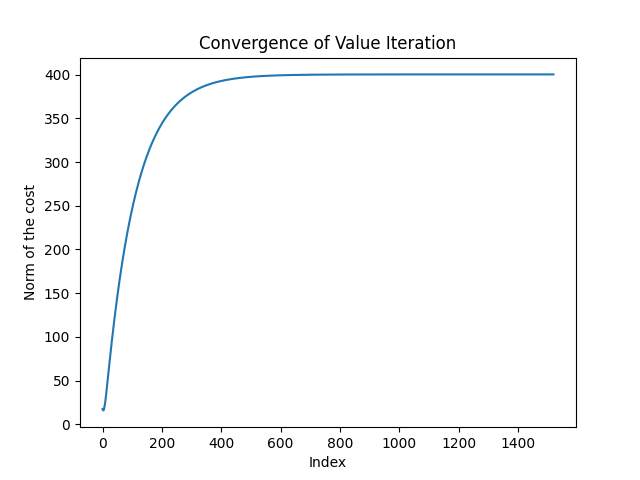

In [3]:
J_VAL_ITER, J_norm_hist_VAL_ITER = grid_world_value_iter(
    MAX_ITER=MAX_ITER, tol=tol, alpha=alpha, g=g)

plt.figure()
plt.plot(J_norm_hist_VAL_ITER)
plt.xlabel("Index")
plt.ylabel("Norm of the cost")
plt.title("Convergence of Value Iteration")
plt.show()

The final thing left to do now is to extract the policy from the converged cost matrix. To do that, we shall follow the steps - 
1. For the current state, find the next best action.
2. Assign this action to the state.
3. Repeat for all states.

The below code has been written on the basis of this idea.

In [ ]:
def extract_policy(J: np.ndarray) -> np.ndarray:
    """
    Extract the optimal policy from the optimal value function for a grid-world.

    The policy determines the best action to take in each cell to minimize the cumulative discounted cost.
    Possible actions are: 'Up', 'Down', 'Left', 'Right', and 'Do nothing'.
    Obstacles are marked as 'Obstacle' in the policy.

    Args:
        J (np.ndarray): A 2D array representing the optimal value function for each cell in the grid-world.
                        - np.nan represents obstacles where no actions are possible.
                        - Other numerical values represent the cost-to-go from that cell.

    Returns:
        np.ndarray: A 2D array of the same shape as `J`, where each element contains the optimal action 
                    ('Up', 'Down', 'Left', 'Right', 'Do nothing') for that cell. Obstacles are marked as 'Obstacle'.
    """
    # Initialize the policy array with 'Obstacle' for all cells
    policy: np.ndarray = np.full(J.shape, 'Obstacle', dtype=object)

    # Iterate over each cell in the grid-world
    for j, k in np.ndindex(J.shape):
        # Skip obstacle cells
        if np.isnan(J[j, k]):
            continue

        # Current cost at cell (j, k)
        J_nothing: float = J[j, k]

        # Initialize costs for all possible actions
        J_left: float = np.inf
        J_right: float = np.inf
        J_up: float = np.inf
        J_down: float = np.inf

        # Calculate cost if the agent decides to move left
        if (0 <= (k - 1) < J.shape[1]) and (~np.isnan(J[j, k - 1])):
            J_left = J[j, k - 1]

        # Calculate cost if the agent decides to move right
        if (0 <= (k + 1) < J.shape[1]) and (~np.isnan(J[j, k + 1])):
            J_right = J[j, k + 1]

        # Calculate cost if the agent decides to move up
        if (0 <= (j - 1) < J.shape[0]) and (~np.isnan(J[j - 1, k])):
            J_up = J[j - 1, k]

        # Calculate cost if the agent decides to move down
        if (0 <= (j + 1) < J.shape[0]) and (~np.isnan(J[j + 1, k])):
            J_down = J[j + 1, k]

        # Determine the minimum cost among all possible actions
        J_min: float = np.inf
        opt_ctrl: str = ''

        # Compare 'Do nothing' action
        if J_nothing < J_min:
            J_min = J_nothing
            opt_ctrl = 'Do nothing'

        # Compare 'Left' action
        if J_left < J_min:
            J_min = J_left
            opt_ctrl = 'Left'

        # Compare 'Right' action
        if J_right < J_min:
            J_min = J_right
            opt_ctrl = 'Right'

        # Compare 'Up' action
        if J_up < J_min:
            J_min = J_up
            opt_ctrl = 'Up'

        # Compare 'Down' action
        if J_down < J_min:
            J_min = J_down
            opt_ctrl = 'Down'

        # Assign the optimal action to the policy for cell (j, k)
        policy[j, k] = opt_ctrl

    # Return the constructed policy
    return policy


print(f"The optimal policy is found to be - \n{extract_policy(J=J_VAL_ITER)}")

The optimal policy is found to be - 
[['Right' 'Right' 'Right' 'Right' 'Do nothing']
 ['Up' 'Obstacle' 'Right' 'Up' 'Up']
 ['Up' 'Left' 'Obstacle' 'Right' 'Down']
 ['Up' 'Left' 'Left' 'Right' 'Do nothing']]


## Solution - Part (b)

Firstly, let us state the Policy Iteration Algorithm over a finite horizon. It is as per Lecture 8 - 

Start with an initial guess for the policy $ \mu_0 $

1. **Policy evaluation step**:  
   Compute $ J_{\mu_n}(x) $ using the policy evaluation algorithm, i.e, solve $(I - \alpha A) J_\mu = \bar{g}$ where $A$ is the system dynamic matrix, $\bar{g}$ is state cost matrix, $\alpha$ is the step size and $J_\mu$ is the value function. 

2. **Policy update step**:  
   Update the policy using

   $$
   \mu_{k+1} = \arg \min_u \, g(x, u) + \alpha J_{\mu_k}(f(x, u))
   $$

Iterate until convergence (happens in a finite number of iterations).


The next thing to do is assign costs for each cell as given. To do that, we shall use the same 2D array as before - 
$$
g(x) = \begin{bmatrix} 0 & 0 & 1 & 0 & -1 \\ 0 & \mathbf{NaN} & 1 & 0 & 10 \\ 0 & 10 & \mathbf{NaN} & 1 & 0 \\ 1 & 0 & 0 & 10 & -1 \end{bmatrix}
$$

The discount factor has been given as $\alpha = 0.99$. 

Now we have all the prerequisites for running the value iteration. The code written below implments this.

In [ ]:
import numpy as np


def grid_world_policy_iter(MAX_ITER: int, tol: float, alpha: float, g: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform Policy Iteration on a grid-world to compute the optimal value function and track convergence history.

    This function iteratively evaluates and improves a policy until convergence is achieved based on the specified tolerance.
    It solves the linear equation (I - alpha * A) J_mu = g to evaluate the current policy and updates the policy by selecting
    the action that minimizes the cost in each state.

    Args:
        MAX_ITER (int): The maximum number of iterations to perform.
        tol (float): The convergence tolerance. Iteration stops when the change in norm is below this value.
        alpha (float): The discount factor for future costs.
        g (np.ndarray): A 2D array representing the grid-world costs.
                        - np.nan represents obstacles where no actions are possible.
                        - Other numerical values represent cell-specific costs.

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - The optimal value function as a 2D array.
            - An array containing the norm history of the value function across iterations.
    """
    # Initialize an array to store the norm of the value function at each iteration
    J_norm_history: np.ndarray = np.zeros(MAX_ITER + 1)

    # Create a mask to identify non-obstacle cells
    mask: np.ndarray = np.ones((g.size, 1), dtype=bool)

    # Define the indices of obstacle cells (flattened index)
    obstacle1: int = 6
    obstacle2: int = 12
    mask[obstacle1] = False
    mask[obstacle2] = False

    # Initialize matrix A for the linear equation (I - alpha * A) J_mu = g
    A: np.ndarray = np.zeros((g.flatten().reshape(-1, 1)[mask].size,
                              g.flatten().reshape(-1, 1)[mask].size))

    # Initialize identity matrix I for the linear equation
    I: np.ndarray = np.eye(g.flatten().reshape(-1, 1)[mask].size,
                           g.flatten().reshape(-1, 1)[mask].size)

    # Override MAX_ITER to 10 (Note: This overwrites the function parameter)
    # If this is intentional, consider renaming the variable to avoid confusion
    MAX_ITER = 10

    # Iterate up to MAX_ITER times
    for i in range(MAX_ITER):
        # Solve the linear equation (I - alpha * A) J_mu = g for the current policy
        J_mu: np.ndarray = np.linalg.solve(
            (I - (alpha * A)), g.flatten().reshape(-1, 1)[mask]
        )

        # Insert np.nan back into the obstacle positions
        J_mu = np.insert(
            np.insert(J_mu, obstacle1, np.nan),
            obstacle2, np.nan
        ).reshape(4, 5)

        # Compute the norm of the current value function (excluding obstacles)
        J_norm_history[i] = np.sqrt(np.nansum(J_mu ** 2))

        # Check for convergence (skip the first iteration)
        if (i != 0) and (abs(J_norm_history[i - 1] - J_norm_history[i]) < tol):
            break

        # Reset matrix A for the next iteration
        A = np.zeros((g.flatten().reshape(-1, 1)[mask].size,
                      g.flatten().reshape(-1, 1)[mask].size))

        # Create an iterator for the rows of matrix A
        A_iterator = enumerate(iter(A))

        # Iterate over each cell in the grid-world
        for j, k in np.ndindex(g.shape):
            # Skip obstacle cells
            if np.isnan(J_mu[j, k]):
                continue

            # Get the current row index in matrix A
            A_row_idx, _ = next(A_iterator, (None, None))

            # Retrieve the current cost at cell (j, k)
            J_nothing: float = J_mu[j, k]

            # Initialize costs for all possible actions to infinity
            J_left: float = np.inf
            J_right: float = np.inf
            J_up: float = np.inf
            J_down: float = np.inf

            # Calculate cost if the agent decides to move left
            if (0 <= (k - 1) < g.shape[1]) and (~np.isnan(J_mu[j, k - 1])):
                J_left = J_mu[j, k - 1]

            # Calculate cost if the agent decides to move right
            if (0 <= (k + 1) < g.shape[1]) and (~np.isnan(J_mu[j, k + 1])):
                J_right = J_mu[j, k + 1]

            # Calculate cost if the agent decides to move up
            if (0 <= (j - 1) < g.shape[0]) and (~np.isnan(J_mu[j - 1, k])):
                J_up = J_mu[j - 1, k]

            # Calculate cost if the agent decides to move down
            if (0 <= (j + 1) < g.shape[0]) and (~np.isnan(J_mu[j + 1, k])):
                J_down = J_mu[j + 1, k]

            # Determine the minimum cost among all possible actions
            J_min: float = np.inf
            opt_ctrl: str = ""
            if J_nothing < J_min:
                J_min = J_nothing
                opt_ctrl = "nothing"
            if J_left < J_min:
                J_min = J_left
                opt_ctrl = "left"
            if J_right < J_min:
                J_min = J_right
                opt_ctrl = "right"
            if J_up < J_min:
                J_min = J_up
                opt_ctrl = "up"
            if J_down < J_min:
                J_min = J_down
                opt_ctrl = "down"

            # Initialize a temporary array to represent the action
            temp: np.ndarray = np.zeros(g.shape)

            # Assign 1 to the cell corresponding to the optimal action
            match opt_ctrl:
                case "nothing":
                    temp[j, k] = 1
                case "left":
                    temp[j, k - 1] = 1
                case "right":
                    temp[j, k + 1] = 1
                case "up":
                    temp[j - 1, k] = 1
                case "down":
                    temp[j + 1, k] = 1
                case _:
                    pass  # No action assigned if no valid move

            # Update the corresponding row in matrix A with the action representation
            A[A_row_idx] = temp.flatten().reshape(-1, 1)[mask]

    # Print the convergence message with the final value function
    print(f"Converged in {i} iterations. Final cost to go - \n{J_mu}")

    # Truncate the norm history to include only the iterations performed
    J_norm_history = J_norm_history[:i + 1]

    # Return the final value function and the norm history
    return J_mu, J_norm_history

Upon convergence, let us now view the final costs and plot the convergence.

Converged in 9 iterations. Final cost to go - 
[[ -95.08   -96.04   -97.01   -99.    -100.   ]
 [ -94.129      nan  -96.03   -98.01   -89.   ]
 [ -93.187  -82.256      nan  -97.01   -99.   ]
 [ -91.256  -90.343  -89.44   -89.    -100.   ]]


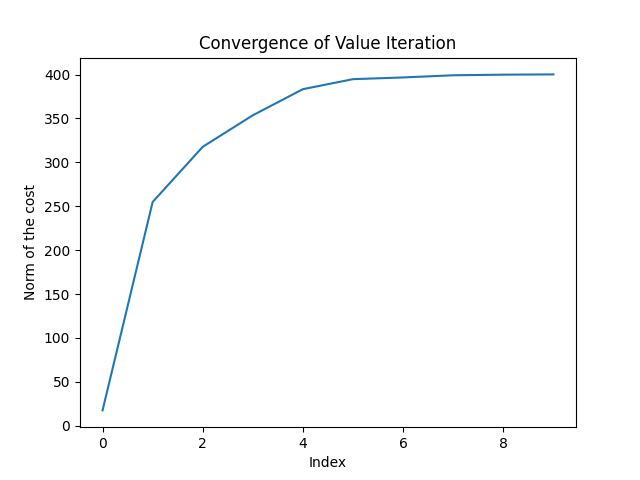

In [ ]:
J_POL_ITER, J_norm_hist_POL_ITER = grid_world_policy_iter(
    MAX_ITER=MAX_ITER, tol=tol, alpha=alpha, g=g)
plt.figure()
plt.plot(J_norm_hist_POL_ITER)
plt.xlabel("Index")
plt.ylabel("Norm of the cost")
plt.title("Convergence of Value Iteration")
plt.show()

The final thing left to do is to extract the optimal policy, for which we shall use the same function defined earlier.

In [7]:
print(f"The optimal policy is found to be - \n{extract_policy(J=J_POL_ITER)}")

The optimal policy is found to be - 
[['Right' 'Right' 'Right' 'Right' 'Do nothing']
 ['Up' 'Obstacle' 'Right' 'Up' 'Up']
 ['Up' 'Left' 'Obstacle' 'Right' 'Down']
 ['Up' 'Left' 'Left' 'Right' 'Do nothing']]


## Solution - Part (c) 

We shall use [cProfile.run()](https://docs.python.org/3/library/profile.html#profile.run) to compute the total time taken by each of the algorithms to reach convergence and then compare the two. Once that is done, we shall compare the two algorithms over various criteria.

In [8]:
# Profile the Value Iteration Algorithm
cProfile.run(
    "grid_world_value_iter(alpha=alpha, tol=tol, g=g, MAX_ITER=MAX_ITER)")

Convergence reached in 1520 iterations. Final cost to go -
[[ -95.079  -96.04   -97.01   -99.    -100.   ]
 [ -94.129      nan  -96.03   -98.01   -89.   ]
 [ -93.187  -82.256      nan  -97.01   -99.   ]
 [ -91.256  -90.343  -89.44   -89.    -100.   ]]
         110009 function calls (109985 primitive calls) in 0.390 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.268    0.268    0.390    0.390 262716759.py:1(grid_world_value_iter)
        1    0.000    0.000    0.390    0.390 <string>:1(<module>)
        6    0.000    0.000    0.000    0.000 _ufunc_config.py:132(geterr)
        6    0.000    0.000    0.000    0.000 _ufunc_config.py:33(seterr)
        3    0.000    0.000    0.000    0.000 _ufunc_config.py:426(__init__)
        3    0.000    0.000    0.000    0.000 _ufunc_config.py:430(__enter__)
        3    0.000    0.000    0.000    0.000 _ufunc_config.py:435(__exit__)
       20    0.000    0.000    0.000    

In [9]:
# Profile the Policy Iteration Algorithm
cProfile.run(
    "grid_world_policy_iter(alpha=alpha, tol=tol, g=g, MAX_ITER=MAX_ITER)")

Converged in 9 iterations. Final cost to go - 
[[ -95.08   -96.04   -97.01   -99.    -100.   ]
 [ -94.129      nan  -96.03   -98.01   -89.   ]
 [ -93.187  -82.256      nan  -97.01   -99.   ]
 [ -91.256  -90.343  -89.44   -89.    -100.   ]]
         2921 function calls (2897 primitive calls) in 0.024 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.008    0.008    0.024    0.024 139305476.py:1(grid_world_policy_iter)
        1    0.000    0.000    0.024    0.024 <string>:1(<module>)
        6    0.000    0.000    0.000    0.000 _ufunc_config.py:132(geterr)
        6    0.000    0.000    0.000    0.000 _ufunc_config.py:33(seterr)
        3    0.000    0.000    0.000    0.000 _ufunc_config.py:426(__init__)
        3    0.000    0.000    0.000    0.000 _ufunc_config.py:430(__enter__)
        3    0.000    0.000    0.000    0.000 _ufunc_config.py:435(__exit__)
       20    0.000    0.000    0.000    0.000 arrayprin

| Criteria | Value Iteration over given Grid World | Policy Iteration over given Grid World |
|----------|----------|----------|
| Logic Idea | Iterate over each value of the policy and minimise the cost to go for each state | Evaluate the entire policy and optimise the full sequence of the cost to go's|
| Optimisation Idea | Optimise only for the current plus the cost to go for the next step | Optimise over the entire sequence of steps from start to end|
| Total number of iterations for convergence| 1520 | 9 |
| Function Calls | 110009 function calls (109985 primitive calls) | 2921 function calls (2897 primitive calls) |
| Time taken for convergence | 0.343 seconds | 0.037 seconds |
| Optimal Policy Comparison | Same as that of the Policy Iteration | Same as that of the Value Iteration |

These results do not provide a strict conclusion that one algorithm is better than the other. As it appears, for the given problem, Policy Iteration provides more robustness over Value Iteration. Results may vary depending on the system.